In [1]:
%load_ext autoreload
%autoreload 2
import glob
import numpy as np
from sklearn.metrics import r2_score
from sklearn import preprocessing
import xgboost as xgb
from collections import defaultdict
from matplotlib import pyplot as plt
import pandas as pd
np.random.seed(42)

In [2]:
file1 = '../datasets/genotype/cas9/10nm/pnas.1700557114.sd01.txt'
file2 = '../datasets/genotype/cas9/10nm/pnas.1700557114.sd02.txt'
file3 = '../datasets/genotype/cas9/10nm/pnas.1700557114.sd03.txt'
file4 = '../datasets/genotype/cas9/10nm/pnas.1700557114.sd04.txt'
file5 = '../datasets/genotype/cas9/1nm/pnas.1700557114.sd05.txt'
file6 = '../datasets/genotype/cas9/1nm/pnas.1700557114.sd06.txt'

In [3]:
letter2int = {'A':1, 'C':2, 'G':3, 'T':4}

def read_cas9_dataset(files):
    signal_original = defaultdict(list) 
    signal_hamming = defaultdict(list)
    
    for file in files:
        with open(file, 'r') as f:
            for line in f.readlines()[1:]:
                tokens = line.split('\t')
                signal_original[tokens[2]] += [float(tokens[5])]
                hamming = np.zeros(len(tokens[1]), np.int32)
                if int(tokens[3]) > 0:
                    positions = np.asarray([int(pos[:-1]) for pos in tokens[2].split(':')])
                    values = np.asarray([letter2int[pos[-1]] for pos in tokens[2].split(':')])
                    hamming[positions] = values
                key_hamming = tuple(hamming.tolist())
                signal_hamming[key_hamming] += [float(tokens[5])]
                
        
    X = np.asarray(list(signal_hamming.keys()))
    Y = np.asarray([np.mean(signal_hamming[key]) for key in signal_hamming.keys()])
    return X, Y, signal_original, signal_hamming

In [4]:
X, Y, s1, s_hamming = read_cas9_dataset([file1, file2, file3, file4, file5, file6])
counts = np.asarray([len(val) for key, val in s_hamming.items()])
means = np.asarray([np.mean(s_hamming[key]) for key in s_hamming.keys()])
stds = np.asarray([np.std(s_hamming[key]) for key in s_hamming.keys()])
#mask = 2*stds < np.abs(means)
mask = counts > 3 # for 1 nm data here I used 0 instead of 3
means_better = means[mask]
X = X[mask]
Y = Y[mask]
#X = X > 0 

train_fraction = 0.8
valid_fraction = 0.1

scaler = preprocessing.StandardScaler().fit(Y[:, np.newaxis])
Y = scaler.transform(Y[:, np.newaxis])[:, 0]
n_train = int(len(X)*train_fraction)
n_valid = int(len(X)*valid_fraction)
perm = np.random.permutation(len(X))
X_train = X[perm[:n_train]]
X_valid = X[perm[n_train:n_train+n_valid]]
X_test = X[perm[n_train+n_valid:]]
Y_train = Y[perm[:n_train]]
Y_valid = Y[perm[n_train:n_train+n_valid]]
Y_test = Y[perm[n_train+n_valid:]]

In [5]:
s_hamming[tuple([1,0,1,1,0,4,0,3,4]+14*[0])]

[0.0001132375, 6.780375e-05, -0.000125826, -5.708235e-05]

In [6]:
counts = np.asarray([len(val) for key, val in s_hamming.items()])

In [7]:
mask.sum()

23716

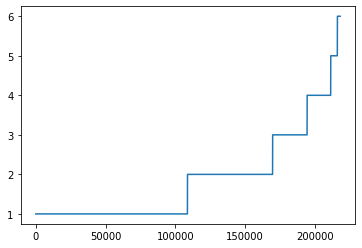

In [8]:
plt.plot(sorted(counts))

In [9]:
est = xgb.XGBRegressor(n_estimators=100)

In [10]:
est.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [11]:
Y_pred = est.predict(X_test)
Y_pred2 = est.predict(X_train)
r2_train = r2_score(Y_train, Y_pred2)
rel_train = np.linalg.norm(Y_train - Y_pred2)/np.linalg.norm(Y_train)
r2 = r2_score(Y_test, Y_pred)
rel = np.linalg.norm(Y_test - Y_pred)/np.linalg.norm(Y_test)

In [12]:
print('TRAIN  R2 score: %2.4f, relative error: %2.4f'%(r2_train, rel_train))
print('TEST   R2 score: %2.4f, relative error: %2.4f'%(r2, rel))

TRAIN  R2 score: 0.4170, relative error: 0.7635
TEST   R2 score: 0.1574, relative error: 0.9176


In [13]:
# X>0:
# XGboost default: 
#  TRAIN  R2 score: 0.3371, relative error: 0.8142
#  TEST   R2 score: 0.1386, relative error: 0.9277

# X hamming:
# XGBoost default:
#  TRAIN  R2 score: 0.4170, relative error: 0.7635
#  TEST   R2 score: 0.1574, relative error: 0.9176

In [14]:
Y

array([ 0.33107297, -0.44970302,  0.96739156, ..., -0.81987339,
        0.50436526, -0.02623936])

In [15]:
def save_csv(X, Y, name):
    df = {}
    for idx, feat in enumerate(X.T):
        df['pos%d'%idx] = feat
    df['y'] = Y
    df = pd.DataFrame(df)
    df.to_csv(name)

save_csv(X, Y, 'cas9_1nm_full.csv')
save_csv(X_train, Y_train, 'cas9_1nm_train.csv')
save_csv(X_valid, Y_valid, 'cas9_1nm_valid.csv')
save_csv(X_test, Y_test, 'cas9_1nm_test.csv')